# Environment

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from Bio import Seq, SeqIO, Entrez
from Bio.Align import PairwiseAligner
from Bio.SeqUtils import complement
import json

In [22]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


# Load functions

In [23]:
# Function to generate the antisense sequence
def generate_antisense(sequence):
    """Generate the antisense sequence."""
    return str(Seq.Seq(sequence).reverse_complement())

# Function to fetch gene sequence from NCBI
# def fetch_gene_sequence(gene_name, email):
#     """Fetch the gene sequence from NCBI."""
#     Entrez.email = email
#     # Search for the gene in the nucleotide database
#     handle = Entrez.esearch(db="nucleotide", term=f"{gene_name}[Gene Name] AND human[Organism]")
#     record = Entrez.read(handle)
#     if record["IdList"]:
#         gene_id = record["IdList"][0]
#         # Fetch the gene record
#         handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="gb", retmode="text")
#         try:
#             gene_record = SeqIO.read(handle, "genbank")
#             return str(gene_record.seq)
#         except ValueError as e:
#             # If there's an error reading the sequence, return None
#             return None
#         finally:
#             handle.close()
#     return None
def fetch_gene_sequence(gene_name, email):
    """Fetch the gene sequence from NCBI using GRCh38 assembly."""
    Entrez.email = email
    # Search for the gene in the nucleotide database, specifically for GRCh38
    search_term = f"{gene_name}[Gene Name] AND human[Organism] AND GRCh38[Assembly]"
    handle = Entrez.esearch(db="nucleotide", term=search_term)
    record = Entrez.read(handle)
    if record["IdList"]:
        gene_id = record["IdList"][0]
        # Fetch the gene record
        handle = Entrez.efetch(db="nucleotide", id=gene_id, rettype="gb", retmode="text")
        try:
            gene_record = SeqIO.read(handle, "genbank")
            return str(gene_record.seq)
        except ValueError as e:
            # If there's an error reading the sequence, return None
            return None
        finally:
            handle.close()
    return None

# Function to perform local alignment between two sequences
def align_sequence(query, target):
    """Perform local alignment and return the best score."""
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 1
    aligner.mismatch_score = -1
    aligner.open_gap_score = -100
    aligner.extend_gap_score = -100
    try:
        alignments = aligner.align(query, target)
        best_alignment = max(alignments, key=lambda a: a.score)
        return {"score": best_alignment.score, "best_alignment": best_alignment}
    except OverflowError:
        print(f"OverflowError occurred during alignment. Query length: {len(query)}, Target length: {len(target)}")
        return 0

# Function to check alignment of antisense sequence with a list of genes
def check_alignment(antisense_seq, gene_list, email, gene_sequences=None):
    """Check alignment of antisense sequence with the given list of genes."""
    results = {}
    for gene in gene_list:
        # Use provided gene sequences if available, otherwise fetch from NCBI
        if gene_sequences is not None:
            gene_seq = gene_sequences.get(gene)
        else:
            gene_seq = fetch_gene_sequence(gene, email)
        if gene_seq:
            score = align_sequence(antisense_seq, gene_seq)
            results[gene] = score
        else:
            print(f"Gene sequence not found for {gene}")
    return results

# Function to check alignment between two genes
def check_gene_alignment(geneA, geneB):
    """Check alignment between two genes."""
    if geneA and geneB:
        alignment_result = align_sequence(geneA, geneB)
        return alignment_result
    else:
        if not geneA:
            print(f"Gene sequence not found for {geneA}")
        if not geneB:
            print(f"Gene sequence not found for {geneB}")
        return None

def check_complementarity(seq1, seq2):
    # Convert sequences to Seq objects and ensure they are uppercase
    seq1 = Seq(seq1.upper())
    seq2 = Seq(seq2.upper())
    
    # Get the complement of seq2
    seq2_complement = complement(seq2)
    
    # Initialize variables to store the longest complementary region
    max_complementary_length = 0
    max_complementary_start1 = 0
    max_complementary_start2 = 0
    
    # Check for complementarity by comparing each position in seq1 with seq2_complement
    for i in range(len(seq1)):
        for j in range(len(seq2_complement)):
            k = 0
            # Continue matching while sequences are complementary and within bounds
            while (i + k < len(seq1) and 
                   j + k < len(seq2_complement) and 
                   seq1[i + k] == seq2_complement[j + k]):
                k += 1
            
            # Update if this is the longest complementary region found so far
            if k > max_complementary_length:
                max_complementary_length = k
                max_complementary_start1 = i
                max_complementary_start2 = j
    
    # Return the length and starting positions of the longest complementary region
    return (max_complementary_length, 
            max_complementary_start1, 
            max_complementary_start2)

def find_longest_complementary_region(antisense_seq, gene_list, gene_sequences):
    """
    Find the longest complementary region between the antisense sequence and each gene.
    
    :param antisense_seq: The antisense sequence to compare
    :param gene_list: List of gene names
    :param gene_sequences: Dictionary of gene sequences
    :return: Dictionary with genes as keys and longest complementary region as values
    """
    result = {}
    for gene in gene_list:
        gene_seq = gene_sequences.get(gene)
        if gene_seq:
            # Set up the aligner with local alignment mode
            aligner = PairwiseAligner()
            aligner.mode = 'local'
            aligner.match_score = 1
            aligner.mismatch_score = -1
            aligner.open_gap_score = -10  # Discourage gaps
            aligner.extend_gap_score = -0.5
            
            # Perform the alignment
            alignments = aligner.align(antisense_seq, gene_seq)
            best_alignment = max(alignments, key=lambda a: a.score)
            
            # Extract the longest contiguous match from the best alignment
            longest_match = ''
            current_match = ''
            for q, t in zip(best_alignment.query, best_alignment.target):
                if q == t:
                    current_match += q
                else:
                    if len(current_match) > len(longest_match):
                        longest_match = current_match
                    current_match = ''
            
            # Check if the last match is the longest
            if len(current_match) > len(longest_match):
                longest_match = current_match
            
            result[gene] = longest_match
        else:
            result[gene] = ''
    
    return result

# Preparation - ASE1 & ASE2 best match


In [24]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

Define genes of interest

In [25]:
selected = ["GEMIN4", "YME1L1", "VCP", "DARS1", "POLR2A", "ORAI1", "POLRMT", "CBX2", "NSD2", "TLE1", "CACNG1", "ZMYND11", "DCAF5", "MED25", "SEMA6A-AS2", "POLD3", "RFT1", "SETDB1", "POLE", "CHD4", "POLR2C", "HTT", "MED14", "PER3", "TOR3A", "EEF1A2", "IL33", "SETD5", "GNRH1", "POLR2E", "IGF1R", "IGF2R", "MTMR1", "EEF2", "RBPMS", "EIF2S3B", "NIPBL", "VCP"]

In [26]:
email = "michal.kubacki11@gmail.com"

Create antisense sequences


In [27]:
antisense_ASE1 = generate_antisense(ASE1)
print(f"Antisense sequence: {antisense_ASE1}")

antisense_ASE2 = generate_antisense(ASE2)
print(f"Antisense sequence: {antisense_ASE2}")

print(len(antisense_ASE1), len(antisense_ASE2))

Antisense sequence: CTTTTCCAAGGAATGTT
Antisense sequence: TTCCGATGAGAATGACG
17 17


# Load gene sequences

Test loading function

In [28]:
fetch_gene_sequence("GEMIN4", email)

'AGCAGGCCTAAGCGCGGCCGCCGTGGCTCCTGCGTCTCCCATCGTGCCGTGCGTCCCGCGCCGCGTTCGAGTTCTCGGAGGGGAGGGGGCGTTAGCCCCGCGCAGCCGCCGGCGTCGCCGCCATGGACCTAGGACCCTTGAACATCTGTGAAGAAATGACTATTCTGCATGGAGGCTTCTTGCTGGCCGAGCAGCTGTTCCACCCTAAGGCACTGGCAGAATTAACAAAGTCTGACTGGGAACGTGTTGGACGGCCCATCGTGGAGGCCTTAAGGGAGATCTCCTCGGCTGCAGCACACTCCCAGCCCTTTGCCTGGAAGAAGAAAGCCCTGATCATCATCTGGGCCAAGGTTCTGCAGCCGCACCCCGTGACCCCGTCCGACACAGAGACACGGTGGCAGGAAGACCTGTTCTTCTCGGTGGGCAACATGATCCCCACCATCAACCACACCATCCTCTTCGAGCTGCTCAAATCCCTGGAAGCTTCTGGACTCTTTATCCAGCTCCTGATGGCCCTGCCCACCACCATCTGCCATGCAGAACTAGAGCGCTTTCTGGAACATGTGACCGTTGACACTTCTGCCGAAGACGTGGCCTTCTTCCTGGACGTCTGGTGGGAGGTGATGAAGCACAAGGGTCACCCGCAGGACCCCCTGCTCTCCCAGTTTAGTGCAATGGCCCATAAGTACCTGCCTGCCTTAGATGAGTTCCCCCATCCTCCAAAGAGGCTTAGGTCAGACCCAGACGCGTGCCCCACCATGCCCCTGTTGGCCATGCTGCTCCGCGGGCTGACACAGATCCAGAGTCGGATCCTGGGCCCGGGGAGGAAGTGCTGTGCGCTGGCCAACCTGGCTGACATGCTGACTGTGTTTGCGCTGACAGAGGACGACCCCCAGGAGGTGTCTGCAACCGTGTATCTGGACAAACTGGCCACGGTGATCTCTGTGTGGAACTCGGACACCCAGAATCCCTACCACCAGCAGGCGCTGGCAGAGAAGG

In [29]:
%%script false --no-raise-error

# Fetch and store gene sequences
gene_sequences = {}
for gene in selected:
    sequence = fetch_gene_sequence(gene, email)
    if sequence:
        gene_sequences[gene] = sequence
    else:
        print(f"Failed to fetch sequence for {gene}")

print(f"Successfully fetched sequences for {len(gene_sequences)} out of {len(selected)} genes")

In [30]:
%%script false --no-raise-error

# Save the gene sequences to a file
with open('./output/gene_sequences.json', 'w') as f:
    json.dump(gene_sequences, f)

print("Gene sequences saved to gene_sequences.json")

In [31]:
# Load the gene sequences from the file
with open('./output/gene_sequences.json', 'r') as f:
    loaded_gene_sequences = json.load(f)

print(f"Loaded {len(loaded_gene_sequences)} gene sequences from file")

Loaded 28 gene sequences from file


# Check alignment with the selected genes

In [32]:
aligned_genes_ASE1 = check_alignment(antisense_ASE1, selected, email, gene_sequences=loaded_gene_sequences)

Gene sequence not found for DARS1
Gene sequence not found for POLR2A
Gene sequence not found for CACNG1
Gene sequence not found for SEMA6A-AS2
Gene sequence not found for POLR2C
Gene sequence not found for TOR3A
Gene sequence not found for EEF1A2
Gene sequence not found for GNRH1
Gene sequence not found for EIF2S3B


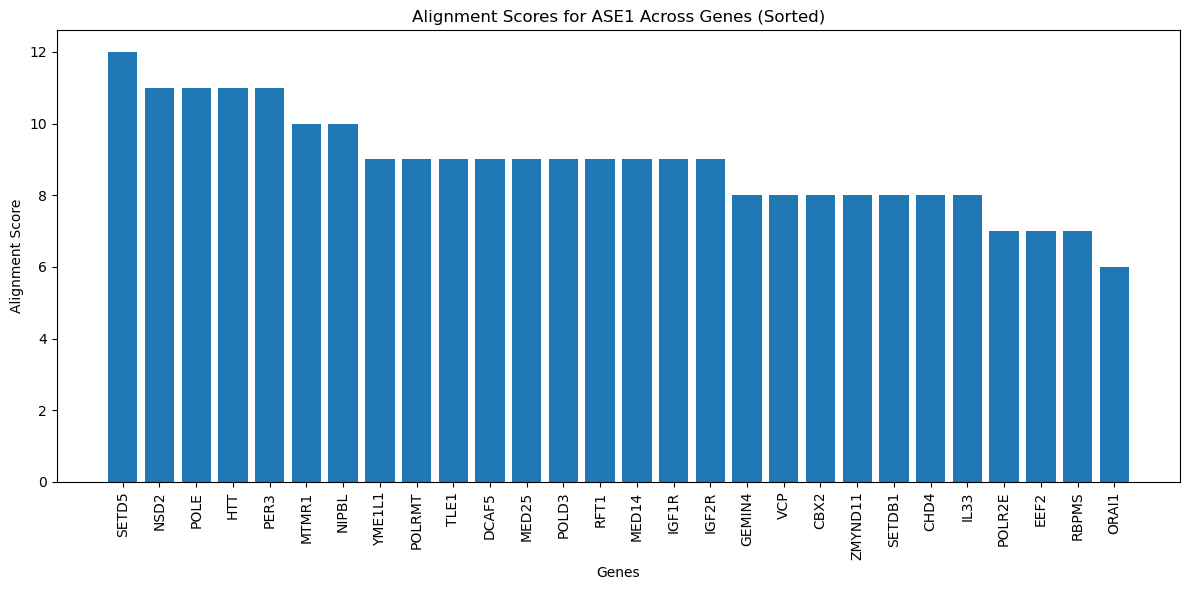

Average alignment score per gene: 8.89
Gene with highest score: SETD5
Gene with lowest score: ORAI1


In [33]:
# Extract scores from aligned_genes_ASE1 and sort them
scores = {gene: data['score'] for gene, data in aligned_genes_ASE1.items()}
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

# Visualize the sorted scores
plt.figure(figsize=(12, 6))
plt.bar(list(sorted_scores.keys()), list(sorted_scores.values()))
plt.title("Alignment Scores for ASE1 Across Genes (Sorted)")
plt.xlabel("Genes")
plt.ylabel("Alignment Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and print some statistics
total_score = sum(scores.values())
avg_score = total_score / len(scores)
print(f"Average alignment score per gene: {avg_score:.2f}")
print(f"Gene with highest score: {next(iter(sorted_scores))}")
print(f"Gene with lowest score: {list(sorted_scores.keys())[-1]}")

In [34]:
# Get the top 5 genes with the highest score
top_5_genes = dict(sorted(aligned_genes_ASE1.items(), key=lambda x: x[1]['score'], reverse=True)[:5])

for gene in top_5_genes.keys():
    print(gene)
    print(aligned_genes_ASE1[gene]["best_alignment"])


SETD5
target            1 TTTTCCAAGGAATG    15
                  0 |||||||||.||||    14
query         38555 TTTTCCAAGAAATG 38569

NSD2
target            0 CTTTTCCAAGGAATG    15
                  0 ||||||..|||||||    15
query         54037 CTTTTCTCAGGAATG 54052

POLE
target            6 CAAGGAATGTT    17
                  0 |||||||||||    11
query         27330 CAAGGAATGTT 27341

HTT
target            0 CTTTTCCAAGGAATG    15
                  0 ||||||.|||||.||    15
query         86766 CTTTTCTAAGGATTG 86781

PER3
target            1 TTTTCCAAGGAATGT   16
                  0 ||||.||||.|||||   15
query          4755 TTTTACAAGTAATGT 4770



In [35]:
aligned_genes_ASE2 = check_alignment(antisense_ASE2, selected, email, gene_sequences=loaded_gene_sequences)


Gene sequence not found for DARS1
Gene sequence not found for POLR2A
Gene sequence not found for CACNG1
Gene sequence not found for SEMA6A-AS2
Gene sequence not found for POLR2C
Gene sequence not found for TOR3A
Gene sequence not found for EEF1A2
Gene sequence not found for GNRH1
Gene sequence not found for EIF2S3B


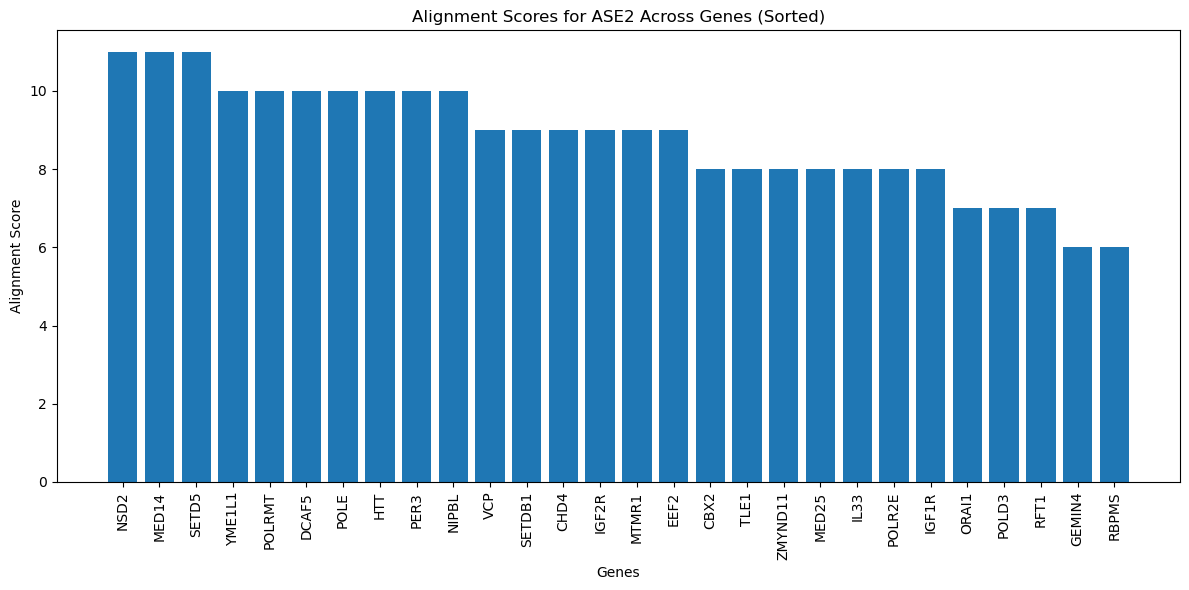

Average alignment score per gene: 8.79
Gene with highest score: NSD2
Gene with lowest score: RBPMS


In [36]:
# Extract scores from aligned_genes_ASE2 and sort them
scores = {gene: data['score'] for gene, data in aligned_genes_ASE2.items()}
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))

# Visualize the sorted scores
plt.figure(figsize=(12, 6))
plt.bar(list(sorted_scores.keys()), list(sorted_scores.values()))
plt.title("Alignment Scores for ASE2 Across Genes (Sorted)")
plt.xlabel("Genes")
plt.ylabel("Alignment Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and print some statistics
total_score = sum(scores.values())
avg_score = total_score / len(scores)
print(f"Average alignment score per gene: {avg_score:.2f}")
print(f"Gene with highest score: {next(iter(sorted_scores))}")
print(f"Gene with lowest score: {list(sorted_scores.keys())[-1]}")

In [37]:
# Get the top 5 genes with the highest score
top_5_genes = dict(sorted(aligned_genes_ASE1.items(), key=lambda x: x[1]['score'], reverse=True)[:5])

for gene in top_5_genes.keys():
    print(gene)
    print(aligned_genes_ASE1[gene]["best_alignment"])


SETD5
target            1 TTTTCCAAGGAATG    15
                  0 |||||||||.||||    14
query         38555 TTTTCCAAGAAATG 38569

NSD2
target            0 CTTTTCCAAGGAATG    15
                  0 ||||||..|||||||    15
query         54037 CTTTTCTCAGGAATG 54052

POLE
target            6 CAAGGAATGTT    17
                  0 |||||||||||    11
query         27330 CAAGGAATGTT 27341

HTT
target            0 CTTTTCCAAGGAATG    15
                  0 ||||||.|||||.||    15
query         86766 CTTTTCTAAGGATTG 86781

PER3
target            1 TTTTCCAAGGAATGT   16
                  0 ||||.||||.|||||   15
query          4755 TTTTACAAGTAATGT 4770



# Snord116 &  Ribosomal 5.8S

In [38]:
# Load the sequence for SNORD116-1 from file
with open('DATA/Snord116', 'r') as file:
    snord116_sequence = file.read().splitlines()[1:]  # Skip the header line
snord116_sequence = ''.join(snord116_sequence)  # Join the lines into a single string

# Print the sequence
print("SNORD116-1 sequence:")
print(snord116_sequence)

# Load the sequence for Ribosome 5.8S from file
with open('DATA/Ribisome_58s', 'r') as file:
    ribosome_58s_sequence = file.read().splitlines()[1:]  # Skip the header line
ribosome_58s_sequence = ''.join(ribosome_58s_sequence)  # Join the lines into a single string

# Print the sequence
print("\nRibosome 5.8S sequence:")
print(ribosome_58s_sequence)

SNORD116-1 sequence:
TGGATCGATGATGAGTCCCCTATAAAAACATTCCTTGGAAAAGCTGAACAAAATGAGTGAGAACTCATAACGTCATTCTCATCGGAACTGAGGTCCA

Ribosome 5.8S sequence:
CGACTCTTAGCGGTGGATCACTCGGCTCGTGCGTCGATGAAGAACGCAGCTAGCTGCGAGAATTAATGTGAATTGCAGGACACATTGATCATCGACACTTCGAACGCACTTGCGGCCCCGGGTTCCTCCCGGGGCTACGCCTGTCTGAGCGTCGCTT


In [39]:
aligned_genes_ribosome = check_gene_alignment(snord116_sequence,ribosome_58s_sequence)


In [40]:
print(aligned_genes_ribosome["best_alignment"])

target            4 TCGATGATGA 14
                  0 |||||||.|| 10
query            33 TCGATGAAGA 43

